# MODEL

In [1]:
import xlrd
import numpy as np
import time
import random
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch as t
from torch.autograd import Variable as V
import torch.nn.functional as F
from math import log

In [2]:
def load_raw_data():
    #print 'loading data...'
    years = 3
    cols = 13
    file_name = [('./data/' + str(i+2010)+'.xlsx') for i in range(years)]
    data = {}
    for i in range(years):
        f = xlrd.open_workbook(file_name[i])
        l = len(f.sheets()[0].col_values(0))
        for j in xrange(l):
            name = f.sheets()[0].row_values(j)[0]
            try:
                data[name][i+2010] = f.sheets()[0].row_values(j)[2:]
                for k in xrange(cols):
                    data[name][i+2010][k] = float(data[name][i+2010][k])
                data[name][i+2010] += [2] if data[name][i+2010][0]>=90 else [1] if (data[name][i+2010][0]<90 and data[name][i+2010][0]>=60) else [0]
            except:
                data[name] = {}
                data[name][i+2010] = f.sheets()[0].row_values(j)[2:]
                for k in xrange(cols):
                    data[name][i+2010][k] = float(data[name][i+2010][k])
                data[name][i+2010] += [2] if data[name][i+2010][0]>=90 else [1] if (data[name][i+2010][0]<90 and data[name][i+2010][0]>=60) else [0]
    return data
data1 = load_raw_data()

In [3]:
def load_env_data():
    file_name = './data/environment_score.xlsx'
    f = xlrd.open_workbook(file_name)
    data = {}
    for i in [0,2,4]:
        year = -i/2 + 2012
        for j in range(200):
            name = f.sheets()[0].row_values(j)[i]
            value = f.sheets()[0].row_values(j)[i+1]
            if value!=0:
                try:
                    data[name][year] = value
                except:
                    data[name] = {}
                    data[name][year] = value
    return data
data2 = load_env_data()

In [4]:
def load_data(data1,data2):
    data = data1.copy()
    ct = []
    yr = [2010,2011,2012]
    for ctr in data:
        ct.append(ctr)
    for ctr in ct:
        if ctr not in data2:
            del data[ctr]
        else:
            for y in yr:
                if y in data[ctr]:
                    if y in data2[ctr]:
                        data[ctr][y].insert(13,data2[ctr][y])  #add environment score
                        # add disaster score
                        data[ctr][y].insert(14, 2.5*log(data2[ctr][y]))
                    else:
                        del data[ctr][y]
    return data
data = load_data(data1,data2)

In [5]:
def get_batch_data(x,y,batchsize=4):
    '''
    raturn Variable s
    '''
    global val_num
    mask = np.array(random.sample(range(498-val_num),batchsize))
    return V(t.from_numpy(x[mask]).type(t.FloatTensor)), V(t.from_numpy(y[mask]).type(t.LongTensor))

In [6]:
def cal_jd(a,b,x):
    '''
    return (x,y)
    '''
    l = len(x)
    for i in range(l-1):
        if (a[i]-b[i])*(a[i+1]-b[i+1])<=0.0:
            return (0.5*(x[i]+x[i+1]), 0.25*(a[i]+b[i]+a[i+1]+b[i+1]))

预处理数据

In [7]:
global val_num
val_num = 50

afg_data = []
for i in data['Afghanistan']:
    afg_data.append(data['Afghanistan'][i])

data_list = []
for i in data:
    if i!='Afghanistan':
        for j in data[i]:
            data_list.append(data[i][j])
random.shuffle(data_list)
data_list = afg_data+data_list
np_data = np.array(data_list)

test_x = t.from_numpy(np_data[:val_num,1:15]).type(t.FloatTensor)
test_y = t.from_numpy(np.array(np_data[:val_num,15], dtype=np.int)).type(t.LongTensor)
train_x = np_data[val_num:,1:15]
train_y = np.array(np_data[val_num:,15], dtype=np.int)

np_x = np_data[:,1:15]
np_y = np.array(np_data[:,15], dtype=np.int)

ts_x = t.from_numpy(np_x).type(t.FloatTensor)
ts_y = t.from_numpy(np_y).type(t.LongTensor)


In [123]:
print data_list[:3]
print afg_data

[[109.3, 9.7, 9.4, 9.7, 8.3, 8.2, 7.2, 10.0, 8.9, 9.2, 9.5, 9.2, 10.0, 5.15, 4.097491786689112, 2], [107.5, 9.8, 9.4, 9.3, 8.0, 8.4, 7.2, 9.7, 8.5, 8.8, 9.1, 9.3, 10.0, 5.2, 4.121646563968454, 2], [106.0, 9.7, 9.4, 9.4, 7.7, 8.1, 7.4, 9.5, 8.5, 8.5, 8.9, 9.0, 10.0, 5.64, 4.324710163774919, 2]]
[[109.3, 9.7, 9.4, 9.7, 8.3, 8.2, 7.2, 10.0, 8.9, 9.2, 9.5, 9.2, 10.0, 5.15, 4.097491786689112, 2], [107.5, 9.8, 9.4, 9.3, 8.0, 8.4, 7.2, 9.7, 8.5, 8.8, 9.1, 9.3, 10.0, 5.2, 4.121646563968454, 2], [106.0, 9.7, 9.4, 9.4, 7.7, 8.1, 7.4, 9.5, 8.5, 8.5, 8.9, 9.0, 10.0, 5.64, 4.324710163774919, 2]]


In [8]:
np.array(data_list).shape

(498, 16)

In [9]:
train_x.shape

(448, 14)

In [10]:
test_x.shape

torch.Size([50, 14])

data为[498,1+12+1+1+1]  #total+data+env+disaster+class

In [11]:
class Net(t.nn.Module):
    def __init__(self, n_hidden=8):
        super(Net,self).__init__()
        self.env = t.nn.Linear(1,12)
        self.out = t.nn.Sequential(
            t.nn.ReLU(inplace=True),
            t.nn.Linear(13, n_hidden),
            t.nn.ReLU(inplace=True),
            t.nn.Linear(n_hidden,3)
        )
    def forward(self,x):
        w1 = self.env(x[:,12:13]) # env score
        y1 = x[:,:12]*(w1) # other data
        y1 = t.cat((x[:,13:], y1), 1) #disaster
        return self.out(y1)

## 训练网络 & 加载模型

In [136]:
net = Net(12)
optimizer = t.optim.SGD(net.parameters(), lr=0.001)
loss_func = t.nn.CrossEntropyLoss()

best_acc = 0.0
acc_list = []
n = 1

for i in range(25000):
    x,y = get_batch_data(train_x,train_y)
    out = net(x)
    loss = loss_func(out,y)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    if i%500==0:
        out = net(V(test_x))
        prediction = t.max(F.softmax(out), 1)[1]
        pred_y = prediction.data.numpy().squeeze()
        target_y = test_y.numpy()
        accuracy = sum(pred_y == target_y)/float(val_num)
        print 'epoch [%d] accuracy: %f' %(i/500,accuracy)
        acc_list.append(accuracy)
        if accuracy>best_acc:
            n = n+1
            t.save(net.state_dict(), 'params%s.pkl'%str(n))
            best_acc = accuracy
print 'best_acc: %f' % best_acc


epoch [0] accuracy: 0.500000
epoch [1] accuracy: 0.660000
epoch [2] accuracy: 0.680000
epoch [3] accuracy: 0.680000
epoch [4] accuracy: 0.720000
epoch [5] accuracy: 0.720000
epoch [6] accuracy: 0.780000
epoch [7] accuracy: 0.780000
epoch [8] accuracy: 0.800000
epoch [9] accuracy: 0.820000
epoch [10] accuracy: 0.800000
epoch [11] accuracy: 0.800000
epoch [12] accuracy: 0.860000
epoch [13] accuracy: 0.800000
epoch [14] accuracy: 0.900000
epoch [15] accuracy: 0.800000
epoch [16] accuracy: 0.800000
epoch [17] accuracy: 0.800000
epoch [18] accuracy: 0.940000
epoch [19] accuracy: 0.880000
epoch [20] accuracy: 0.940000
epoch [21] accuracy: 0.940000
epoch [22] accuracy: 0.940000
epoch [23] accuracy: 0.940000
epoch [24] accuracy: 0.860000
epoch [25] accuracy: 0.900000
epoch [26] accuracy: 0.940000
epoch [27] accuracy: 0.960000
epoch [28] accuracy: 0.920000
epoch [29] accuracy: 0.960000
epoch [30] accuracy: 0.920000
epoch [31] accuracy: 0.940000
epoch [32] accuracy: 0.960000
epoch [33] accuracy:

In [12]:
net = Net(12)
net.load_state_dict(t.load('params14.pkl'))
out = net(V(ts_x))
prediction = t.max(F.softmax(out), 1)[1]
pred_y = prediction.data.numpy().squeeze()
target_y = ts_y.numpy()
accuracy = sum(pred_y == target_y)/498.0
accuracy

0.93775100401606426

查找data中的元素属性

In [13]:
tens = ['South Sudan','Somalia','Central African Republic','Yemen',
       'Sudan', 'Syria', 'Democratic Republic of Congo', 'Chad', 
        'Afghanistan', 'Iraq']
exist_tens = ['Somalia', 'Central African Republic', 'Sudan', 'Syria', 'Chad', 'Afghanistan', 'Iraq']
print data[ 'Afghanistan']

{2010: [109.3, 9.7, 9.4, 9.7, 8.3, 8.2, 7.2, 10.0, 8.9, 9.2, 9.5, 9.2, 10.0, 5.15, 4.097491786689112, 2], 2011: [107.5, 9.8, 9.4, 9.3, 8.0, 8.4, 7.2, 9.7, 8.5, 8.8, 9.1, 9.3, 10.0, 5.2, 4.121646563968454, 2], 2012: [106.0, 9.7, 9.4, 9.4, 7.7, 8.1, 7.4, 9.5, 8.5, 8.5, 8.9, 9.0, 10.0, 5.64, 4.324710163774919, 2]}


## 绘图

### 数据分布饼状图

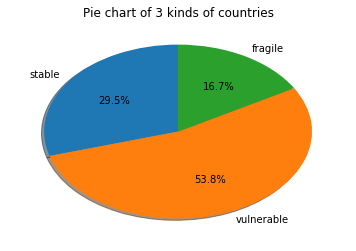

In [147]:
labels = ['stable','vulnerable','fragile']
count = [0,0,0]
for i in data_list:
    count[i[15]] += 1
for i in range(3):
    count[i] /= 498.0
plt.pie(x=count,labels=labels,
        autopct='%3.1f%%',
        shadow=True,
        startangle=90
       )
plt.title('Pie chart of 3 kinds of countries')
plt.show()

### 收敛曲线

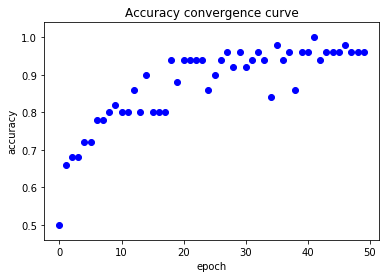

In [138]:
plt.figure()
x = range(len(acc_list))
plt.scatter(x, acc_list,c='b',marker='o')
plt.title('Accuracy convergence curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close()

网络结构

In [12]:
net

Net (
  (env): Linear (1 -> 12)
  (out): Sequential (
    (0): ReLU (inplace)
    (1): Linear (13 -> 12)
    (2): ReLU (inplace)
    (3): Linear (12 -> 3)
  )
)

In [107]:
x = V(t.Tensor([[1,1,1,1,1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1,1,1,1]]))
#,[1,1,1,1,1,1,1,1,1,1,1,1,1]]))
net = Net()
out = net(x)
y = V(t.LongTensor([0,1]))
loss_func = t.nn.CrossEntropyLoss()
loss = loss_func(out,y)
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
optimizer.zero_grad()
loss.backward()
loss

数据平均值

In [41]:
avg_data=[]
for i in range(15):
    avg_data.append(np.sum(np_data[:,i])/498.0)

### 数据3d散点图

In [182]:
plt.scatter??

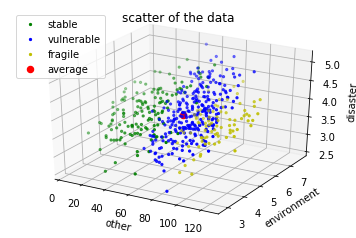

In [188]:
d = [[[],[],[]], [[],[],[]], [[],[],[]]]
for i in range(498):
    d[int(np_data[i,15])][0].append(np_data[i,0]+35*(random.random()-0.5))
    d[int(np_data[i,15])][1].append(np_data[i,13])
    d[int(np_data[i,15])][2].append(np_data[i,14])
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(d[0][0], d[0][1],d[0][2], c='g', marker = '.')
ax.scatter(d[1][0], d[1][1],d[1][2], c='b', marker = '.')
ax.scatter(d[2][0], d[2][1],d[2][2], c='y', marker = '.')
ax.scatter(avg_data[0],avg_data[13],avg_data[14],c='r',marker='o',linewidth=3)
ax.legend(('stable','vulnerable','fragile','average'))
ax.set_xlabel('other')
ax.set_ylabel('environment')
ax.set_zlabel('disaster')
ax.set_title('scatter of the data')
plt.show()

输出随环境变化

### 阿富汗(fragile)

4.09749178669 0.853757560253


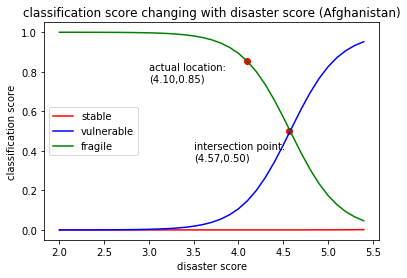

In [237]:
env_x = np.arange(2.0,5.5,0.1)
afg_data = data[ 'Afghanistan'][2010][1:15]
input_afg = np.array([afg_data]*35)
input_ = input_afg.copy()
input_[:,13] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data[ 'Afghanistan'][2010][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
y = [[],[],[]]
for i in range(3):
    for j in range(35):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
jd_point = cal_jd(y[1],y[2],env_x)
ax.scatter(jd_point[0]+0.02,jd_point[1],c='r')
ax.scatter(afg_data[13],act_score[2][0],c='r')
print afg_data[13],act_score[2][0]
ax.set_xlabel('disaster score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with disaster score (Afghanistan)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(3.5,0.35,'intersection point: \n(4.57,0.50)')
plt.text(3,0.75,'actual location: \n(4.10,0.85)')
plt.show()

(4.3500000000000014, 0.4999445453286171)
5.15 0.853757560253


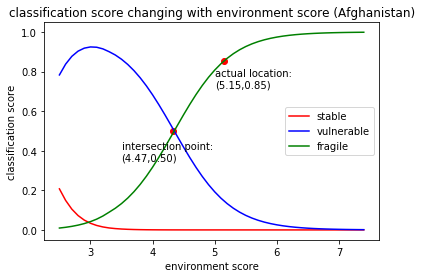

In [204]:
env_x = np.arange(2.5,7.5,0.1)
afg_data = data[ 'Afghanistan'][2010][1:15]
input_afg = np.array([afg_data]*50)
input_ = input_afg.copy()
input_[:,12] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data[ 'Afghanistan'][2010][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
y = [[],[],[]]
for i in range(3):
    for j in range(50):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
jd_point = cal_jd(y[1],y[2],env_x)
print jd_point
ax.scatter(jd_point[0]-0.02,jd_point[1],c='r')
ax.scatter(afg_data[12],act_score[2][0],c='r')
print afg_data[12],act_score[2][0]
ax.set_xlabel('environment score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with environment score (Afghanistan)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(3.5,0.35,'intersection point: \n(4.47,0.50)')
plt.text(5,0.72,'actual location: \n(5.15,0.85)')
plt.show()

### 弱势

(4.0500000000000016, 0.49992144107818604)
4.33797279435 0.742711484432


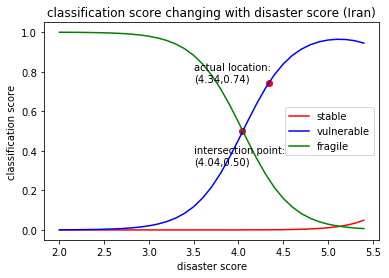

In [259]:
env_x = np.arange(2.0,5.5,0.1)
afg_data = data[ 'Iran'][2012][1:15]
input_afg = np.array([afg_data]*35)
input_ = input_afg.copy()
input_[:,13] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data[ 'Afghanistan'][2010][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
y = [[],[],[]]
for i in range(3):
    for j in range(35):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
jd_point = cal_jd(y[1],y[2],env_x)
print jd_point
ax.scatter(jd_point[0]-0.01,jd_point[1],c='r')
ax.scatter(afg_data[13],act_score[1][0],c='r')
print afg_data[13],act_score[1][0]
ax.set_xlabel('disaster score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with disaster score (Iran)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(3.5,0.33,'intersection point: \n(4.04,0.50)')
plt.text(3.5,0.75,'actual location: \n(4.34,0.74)')
plt.show()

(6.150000000000003, 0.49995286017656326)
(3.5500000000000007, 0.499032624065876)
5.67 0.742711484432


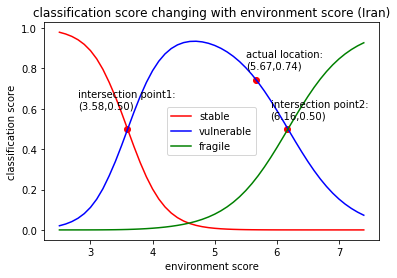

In [250]:
env_x = np.arange(2.5,7.5,0.1)
afg_data = data[ 'Iran'][2012][1:15]
input_afg = np.array([afg_data]*50)
input_ = input_afg.copy()
input_[:,12] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data['Iran'][2012][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
#print prediction
y = [[],[],[]]
for i in range(3):
    for j in range(50):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
jd_point2 = cal_jd(y[1],y[2],env_x)
print jd_point2
jd_point1 = cal_jd(y[0],y[1],env_x)
print jd_point1
ax.scatter(jd_point1[0]+0.03,jd_point1[1],c='r')
ax.scatter(jd_point2[0]+0.01,jd_point2[1],c='r')
ax.scatter(afg_data[12],act_score[1][0],c='r')
print afg_data[12],act_score[1][0]
ax.set_xlabel('environment score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with environment score (Iran)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(5.9, 0.55,'intersection point2: \n(6.16,0.50)')
plt.text(2.8, 0.6,'intersection point1: \n(3.58,0.50)')
plt.text(5.5, 0.8,'actual location: \n(5.67,0.74)')
plt.show()

### 稳定(stable) 

3.66968587028 0.968383789062


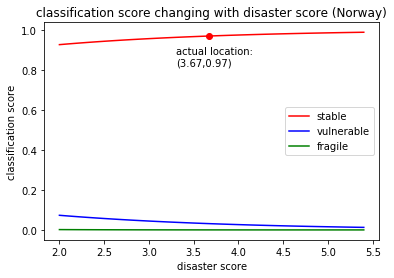

In [14]:
env_x = np.arange(2.0,5.5,0.1)
afg_data = data[ 'Norway'][2010][1:15]
input_afg = np.array([afg_data]*35)
input_ = input_afg.copy()
input_[:,13] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data[ 'Afghanistan'][2010][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
y = [[],[],[]]
for i in range(3):
    for j in range(35):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
#jd_point = cal_jd(y[1],y[2],env_x)
#ax.scatter(jd_point[0]+0.02,jd_point[1],c='r')
ax.scatter(afg_data[13],act_score[0][0],c='r')
print afg_data[13],act_score[0][0]
ax.set_xlabel('disaster score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with disaster score (Norway)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(3.3,0.82,'actual location: \n(3.67,0.97)')
plt.show()

None
4.34 0.968383789062


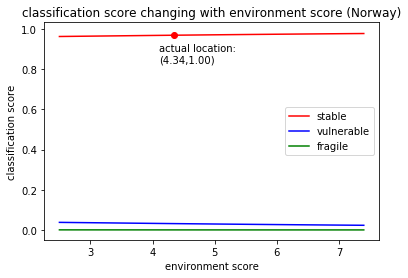

In [215]:
env_x = np.arange(2.5,7.5,0.1)
afg_data = data[ 'Norway'][2010][1:15]
input_afg = np.array([afg_data]*50)
input_ = input_afg.copy()
input_[:,12] = env_x
scores = F.softmax(net(V(t.Tensor(input_)))).data.t()
act_score = F.softmax(net(V(t.Tensor(np.array([afg_data]))))).data.t()
#print F.softmax(net(V(t.Tensor(np.array([data[ 'Afghanistan'][2010][1:15]]))))).data.t()
prediction = t.max(F.softmax(net(V(t.Tensor(input_)))), 1)[1]
y = [[],[],[]]
for i in range(3):
    for j in range(50):
        y[i].append(scores[i][j])
plt.figure()
ax = plt.subplot(111)
ax.plot(env_x, y[0], c='r')
ax.plot(env_x, y[1], c='b')
ax.plot(env_x, y[2], c='g')
jd_point = cal_jd(y[1],y[2],env_x)
print jd_point
#ax.scatter(jd_point[0]-0.02,jd_point[1],c='r')
ax.scatter(afg_data[12],act_score[0][0],c='r')
print afg_data[12],act_score[0][0]
ax.set_xlabel('environment score')
ax.set_ylabel('classification score')
ax.set_title('classification score changing with environment score (Norway)')
plt.legend(('stable','vulnerable','fragile'))
plt.text(4.1,0.83,'actual location: \n(4.34,1.00)')
plt.show()

查看模型参数

In [15]:
for param in net.parameters():
    print(type(param.data), param.size(),param)

(<class 'torch.FloatTensor'>, torch.Size([12, 1]), Parameter containing:
-0.1798
 0.5612
-0.4593
-0.5999
 0.2822
 0.3394
-0.1344
 0.0251
-0.7828
-0.2574
-0.1628
-0.7441
[torch.FloatTensor of size 12x1]
)
(<class 'torch.FloatTensor'>, torch.Size([12]), Parameter containing:
 0.3608
 0.1216
 0.3631
-0.5044
 0.0226
 0.2633
-0.4302
 0.8356
-0.3208
-0.3902
 0.5352
 0.7259
[torch.FloatTensor of size 12]
)
(<class 'torch.FloatTensor'>, torch.Size([12, 13]), Parameter containing:

Columns 0 to 9 
-0.0995 -0.0458 -0.2338  0.0450  0.2246  0.0739  0.2213  0.0481 -0.1107  0.1059
 0.0475 -0.2737 -0.2388 -0.2119  0.1679  0.2685 -0.0357 -0.2286 -0.0214  0.2063
 0.0159  0.1735 -0.2413 -0.2093 -0.0166 -0.0713 -0.1250  0.0128 -0.0445 -0.1419
-0.2253 -0.1564 -0.2651 -0.2441 -0.0386  0.2326  0.0301  0.2330 -0.0130 -0.1005
-0.0399 -0.0182 -0.3487  0.2216  0.0300 -0.0479  0.1559 -0.1968  0.2115  0.0193
-1.5287  0.1411  0.3237 -0.2615 -0.0403 -0.0871  0.2450  0.0629  0.5423  0.1445
 0.0243  0.0516 -0.2031  0